In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable 
from matplotlib.colors import Normalize, to_rgba
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.integrate import solve_ivp
import socket
from sklearn.metrics import r2_score
import sys

sys.path.append('..')
from data_utils import *
from plot_utils import barplot_annotate_brackets

plt.style.use('../sci_style.py')

In [3]:
if socket.gethostname() == 'millerlab-endeavourOS':
    img_save_dir = "/home/adameisen/Documents/data/ChaoticConsciousness/images"
    data_save_dir = "/home/adameisen/Documents/data/ChaoticConsciousness/figure_data"
else:
    img_save_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/images"
    data_save_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/figure_data"

# Load Data

In [4]:
# # session = 'Mary-Anesthesia-20160912-02'
# # session = 'MrJones-Anesthesia-20160109-01'
# # session = 'Mary-Anesthesia-20160826-02'
# # session = 'MrJones-Anesthesia-20160107-01'
# # session = 'Mary-Anesthesia-20160822-02'
# # session = 'MrJones-Anesthesia-20160113-01'
# # session = 'Mary-Anesthesia-20160809-01'
# # session = 'MrJones-Anesthesia-20160121-01'
# # session = 'Mary-Anesthesia-20160831-02'
# session = 'MrJones-Anesthesia-20160105-01'

# session_list = ['Mary-Anesthesia-20160912-02',
# 'MrJones-Anesthesia-20160109-01',
# 'Mary-Anesthesia-20160826-02',
# 'MrJones-Anesthesia-20160107-01']

# max_freq = 500
# max_unstable_freq = 125
norm = False
subsample = 1

if socket.gethostname() == 'millerlab-endeavourOS':
    results_dir = "/home/adameisen/Documents/data/ChaoticConsciousness/stability_results_redone/stability_results"
else:
    results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/stability_results_redone/stability_results'

session_list = os.listdir(results_dir)

In [5]:
session_rets = {}
for session in tqdm(session_list):
    print("-"*30)
    print(f'SESSION = {session}')
    print("-"*30)
    session_rets[session] = {}
    # ---------------------------------
    # LOAD DATA
    # --------------------------------
    print("loading data...")
    if socket.gethostname() == 'millerlab-endeavourOS':
        all_data_dir = "/home/adameisen/millerdata/data/common/datasets/anesthesia/mat"
    else:
        all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
    data_class = get_data_class(session, all_data_dir)

    os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
    # variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    # session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    # electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

    variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=True)
    electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

    eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
    eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

    section_times = dict( 
            wake=(0, session_info['drugStart'][0]),
            induction=(session_info['drugStart'][0], eyes_close),
            anesthesia=(eyes_close, session_info['drugEnd'][1]),
            recovery=(session_info['drugEnd'][1], T*dt)
    )
    sections = list(section_times.keys())
    
    session_rets[session]['electrode_info'] = electrode_info
    session_rets[session]['unit_info'] = unit_info
    session_rets[session]['lfp'] = lfp
    session_rets[session]['session_info'] = session_info
    session_rets[session]['eyes_open'] = eyes_open
    session_rets[session]['eyes_close'] = eyes_close
    session_rets[session]['section_times'] = section_times
    session_rets[session]['sections'] = sections
    
    print("data loaded!")
    print("loading results...")
    norm_dir = "NORMED" if norm else "NOT_NORMED"
    subsample_dir = f"SUBSAMPLE_{subsample}" if "redone" in results_dir else ""
    total = 0
    for area in os.listdir(os.path.join(results_dir, session, norm_dir, subsample_dir)):
        total += len(os.listdir(os.path.join(results_dir, session, norm_dir, subsample_dir, area)))
    
    results_dict = {}
    iterator = tqdm(total=total)
    for area in os.listdir(os.path.join(results_dir, session, norm_dir, subsample_dir)):
        results_dict[area] = None
        for f in os.listdir(os.path.join(results_dir, session, norm_dir, subsample_dir, area)):
            if 'redone' in results_dir:
                df = pd.read_pickle(os.path.join(results_dir, session, norm_dir, subsample_dir, area, f))
                df['area'] = area
                df['start_time'] = df['window_start']
                df['end_time'] = df['window_end']
                df['start_ind'] = int(df['window_start']/dt)
                df['end_ind'] = int(df['window_end']/dt)
                df = pd.DataFrame([df])

                if results_dict[area] is None:
                    results_dict[area] = df
                else:
                    results_dict[area] = pd.concat([results_dict[area], df])
            
            else:
                t = float(f.split('_')[0])
                df = pd.DataFrame(pd.read_pickle(os.path.join(results_dir, session, norm_dir, subsample_dir, area, f)))
                if len(df) > 0:
                    df['area'] = area
                    df['start_time'] = t
                    df['end_time'] = t + df.window*dt
                    df['start_ind'] = int(t/dt)
                    df['end_ind'] = int(t/dt) + df.window
    
                    if results_dict[area] is None:
                        results_dict[area] = df
                    else:
                        results_dict[area] = pd.concat([results_dict[area], df])
                else:
                    print(f"{area}/{f} is empty")
            iterator.update()
        results_dict[area] = results_dict[area].sort_values('start_time')
    
    session_rets[session]['results_dict'] = results_dict

    raise ValueError
    
    print("results loaded!")
    iterator.close()

  0%|          | 0/21 [00:00<?, ?it/s]

------------------------------
SESSION = MrJones-Anesthesia-20160105-01
------------------------------
loading data...
Loading data: ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']...
electrodeInfo : dict with keys[NSP,Properties,area,array,channel,chnlID,electrode,file,gridLoc,hasLFP,hemisphere,numUnits,session,]

lfp : numpy.array(12474902,227,) of type float64

lfpSchema : dict with keys[dataDim,dataUnits,description,dims,history,index,indexUnits,mask,smpInterval,smpRate,timeUnits,userData,]

sessionInfo : dict with keys[NSPs,Properties,areas,arrays,drug,drugDose,drugDuration,drugEnd,drugStart,drugTask,eyesClose,eyesOpen,hasDrug,hasWakeUpTest,numCorrect,numTrials,pctBadTrials,pctCorrect,session,subject,tasks,]

trialInfo : dict with keys[Properties,badTimingTrials,badTrials,cpt_puffOff,cpt_puffOn,cpt_refTime,cpt_toneOff,cpt_toneOn,cpt_trialType,drugPhase,drugPhaseTime,refTime,sac_correct,sac_delayEnd,sac_delayLength,sac_fixationTime,sac_fixptOn,sac_outc

  0%|          | 0/4150 [00:00<?, ?it/s]

ValueError: 

In [11]:
len(unit_info['chnlID'])

408

In [15]:
len(np.unique(unit_info['chnlID']))

181

In [ ]:
unit_info['ch

In [13]:
len(unit_info['area'])

408

# Electrode Separation

In [ ]:
for session, session_dict in session_rets.items():
    break

In [ ]:
session_dict.keys()

In [73]:
window_length = 180 # s
start_times = np.arange(int(lfp.shape[0]*dt/window_length))*window_length
lfp_means_over_time = np.zeros((len(start_times), lfp.shape[-1]))
lfp_stds_over_time = np.zeros((len(start_times), lfp.shape[-1]))
for i, start_time in tqdm(enumerate(start_times), total=len(start_times)):
    lfp_means_over_time[i] = lfp[int(start_time/dt):int((start_time + window_length)/dt)].mean(axis=0)
    lfp_stds_over_time[i] = lfp[int(start_time/dt):int((start_time + window_length)/dt)].std(axis=0)

  0%|          | 0/69 [00:00<?, ?it/s]

In [74]:
start = -15
end = 85
time_vals = (start_times - session_info['drugStart'][0])/60
time_inds = (time_vals >= start) & (time_vals <= end)
np.max(lfp_means_over_time[time_inds].max(axis=0)*100/lfp_stds_over_time[time_inds].min(axis=0))

10.22298844856514

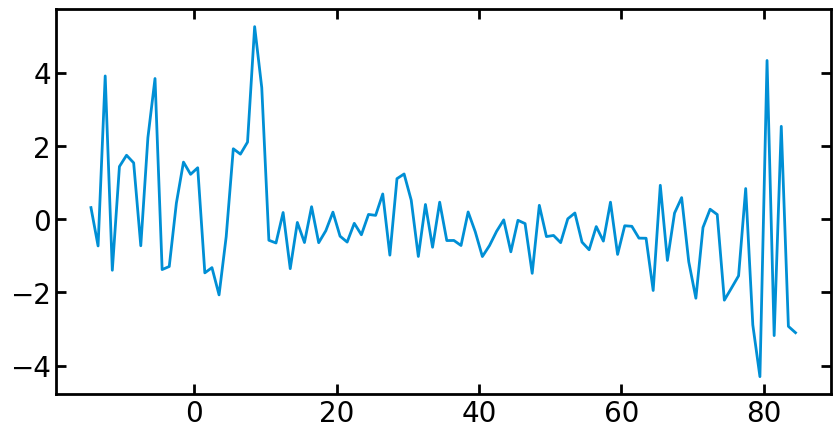

In [63]:


plt.plot(time_vals[time_inds], lfp_means_over_time[time_inds, 0]*100/lfp_stds_over_time[time_inds, 0])
# plt.plot(time_vals[time_inds], np.diff(lfp_means_over_time, axis=0)[time_inds[1:], 0]*100/lfp_stds_over_time[time_inds, 0])
# plt.plot(time_vals[time_inds], lfp_means_over_time[time_inds, 0]*100/lfp_stds_over_time[time_inds, 0])
# plt.plot(time_vals[time_inds], np.diff(lfp_means_over_time, axis=0)[time_inds[1:], 0])